# Chapter 8 Introduction to Deep Learning for Computer Vision

This chapter introduces convolutional neural networks, also known as convnets, the
 type of deep learning model that is now used almost universally in computer vision
 applications. You’ll learn to apply convnets to image-classification problems—in particular those involving small training datasets, which are the most common use case i 
 you aren’t a large tech company

## 8.1 Introduction to convnets

First, let’s take a practical look at a simple convnet example that classifies MNIST digits, a task we performed in chapter 2 using a
densely connected network (our test accuracy then was 97.8%). Even though the
convnet will be basic, its accuracy will blow our densely connected model from chapter 2 out of the water

The following listing shows what a basic convnet looks like. 

It’s a stack of Conv2D and MaxPooling2D layers. 

You’ll see in a minute exactly what they do. We’ll build the
model using the Functional API, which we introduced in the previous chapter.

In [1]:
from tensorflow import keras
from keras import layers

In [3]:
inputs = keras.Input(shape=(28,28,1))

x = layers.Conv2D(filters=32,kernel_size=3,activation='relu')(inputs)
x = layers.MaxPooling2D(pool_size=2)(x)
x = layers.Conv2D(filters=64,kernel_size=3,activation='relu')(x)
x = layers.MaxPooling2D(pool_size=2)(x)
x = layers.Conv2D(filters=128,kernel_size=3,activation='relu')(x)
x = layers.Flatten()(x)
outputs = layers.Dense(10,activation='softmax')(x)

model = keras.Model(inputs = inputs,outputs=outputs)




Importantly, a convnet takes as input tensors of shape __(image_height, image_width,
image_channels)__, not including the batch dimension. 

In this case, we’ll configure the
convnet to process inputs of size __(28, 28, 1)__, which is the format of MNIST images.

Listing 8.2 Displaying the model’s summary

In [15]:
model.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 28, 28, 1)]       0         
                                                                 
 conv2d_3 (Conv2D)           (None, 26, 26, 32)        320       
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 13, 13, 32)       0         
 2D)                                                             
                                                                 
 conv2d_4 (Conv2D)           (None, 11, 11, 64)        18496     
                                                                 
 max_pooling2d_3 (MaxPooling  (None, 5, 5, 64)         0         
 2D)                                                             
                                                                 
 conv2d_5 (Conv2D)           (None, 3, 3, 128)         7385

1. You can see that the output of every Conv2D and MaxPooling2D layer is a rank-3 tensor
of shape (height, width, channels). The width and height dimensions tend to
shrink as you go deeper in the model. The number of channels is controlled by the
first argument passed to the Conv2D layers (32, 64, or 128).


2. After the last Conv2D layer, we end up with an output of shape (3, 3, 128)—a 3 × 3
feature map of 128 channels. The next step is to feed this output into a densely connected classifier like those you’re already familiar with: a stack of Dense layers. These
classifiers process vectors, which are 1D, whereas the current output is a rank-3 tensor.


3. To bridge the gap, we flatten the 3D outputs to 1D with a Flatten layer before adding
the Dense layers.
 
 
4. Finally, we do 10-way classification, so our last layer has 10 outputs and a softmax
activation.

Now, let’s train the convnet on the MNIST digits. We’ll reuse a lot of the code from
 the MNIST example in chapter 2. 
 
Because we’re doing 10-way classification with a
 softmax output, we’ll use the categorical crossentropy loss, and because our labels are
 integers, we’ll use the sparse version, sparse_categorical_crossentropy.

Listing 8.3 Training the convnet on MNIST images

In [9]:
from keras.datasets import mnist
import numpy as np

(train_images,train_labels),(test_images,test_labels) = mnist.load_data()
train_images = train_images.reshape((60000,28,28,1))
train_images = train_images.astype('float32')/255

test_images = test_images.reshape((10000,28,28,1))
test_images = test_images.astype('float32')/255



In [11]:
model.compile(
    optimizer = keras.optimizers.RMSprop(),
    loss = keras.losses.SparseCategoricalCrossentropy(),
    metrics = ['accuracy']
)

model.fit(train_images,train_labels,epochs=5,batch_size=64)

Epoch 1/5
938/938 [==============================] - 13s 8ms/step - loss: 0.1518 - accuracy: 0.9530
Epoch 2/5
938/938 [==============================] - 7s 7ms/step - loss: 0.0431 - accuracy: 0.9866
Epoch 3/5
938/938 [==============================] - 7s 8ms/step - loss: 0.0296 - accuracy: 0.9910
Epoch 4/5
938/938 [==============================] - 8s 8ms/step - loss: 0.0226 - accuracy: 0.9930
Epoch 5/5
938/938 [==============================] - 8s 8ms/step - loss: 0.0173 - accuracy: 0.9949


Let's check the evaluation accuacy

In [12]:
test_loss, test_acc = model.evaluate(test_images,test_labels)
print("Test Accuracy: {}".format(test_acc))

313/313 [==============================] - 2s 6ms/step - loss: 0.0258 - accuracy: 0.9916
Test Accuracy: 0.991599977016449


### 8.1.1 The convolution operation

The Foundamental difference between a __densely connected layer__ and a __convolution layer__:

__Dense layers__ learn __global patterns__ in their input feature space (for exam ple, for a MNIST digit, patterns involving all pixels), 

whereas __convolution layers__ learn
 __local patterns__—in the case of images, patterns found in small 2D windows of the
 inputs, in previous example, this window has size of 3x3

This Key characteristic gives convnets TWO interesting properties:

1. The patterns they learn are ${translation-invariant}$. 

After learning a certain pattern in
the lower-right corner of a picture, a convnet can recognize it anywhere: for
example, in the upper-left corner. A densely connected model would have to
learn the pattern anew if it appeared at a new location. 

This makes convnets data-efficient when processing images (because the visual world is fundamentally
translation-invariant): they need fewer training samples to learn representations
that have generalization power.

2. They can learn ${spatial}$ ${hierarchies}$ ${of}$ ${patterns}$. 

A first convolution layer will learn
small local patterns such as edges, a second convolution layer will learn larger
patterns made of the features of the first layers, and so on

This allows convnets to efficiently learn increasingly complex and abstract visual concepts, because the visual world is fundamentally spatially hierarchical

Convolutions operate over rank-3 tensors called ${feature}$ ${maps}$: 

With two $spatial$ $axes$
(height and width) as well as a $depth$ $axis$ (also called the channels axis). 

+ For an RGB image, the dimension of the depth axis is 3, because the image has three color channels: red, green, and blue. 

+ For a black-and-white picture, like the MNIST digits, the
depth is 1 (levels of gray).

The convolution operation extracts patches from its $input$
$feature$ $map$ and applies the same transformation to all of these patches, producing
an $output$ $feature$ $map$.

$output$ $feature$ $map$:

+ Has  $spatial$ $axes$ size maybe not same as input

+ Its $depth$ can be __arbitrary__, because the output depth is a parameter of the
    layer, and the different channels in that __depth axis__  __no longer__ stand for specific __colors__
    as in RGB input; rather, they stand for __filters__.

__Filters__ encode specific aspects of the
 input data: at a high level, a single filter could encode the concept “presence of a face
 in the input,

In the MNIST example, the first convolution layer takes a feature map of size __(28,
28, 1)__ and __outputs__ a feature map of size __(26, 26, 32)__: it computes __32 filters__ over its
input. 

__Each__ of these 32 output channels __contains a 26 × 26 grid of values__, which is a
__response map of the filter over the input__, indicating the response of that filter pattern at
different locations in the input

That is what the term $feature$ $map$ means: 

Every dimension in the __depth axis__ is a __feature
(or filter)__ , and the $nth$ __rank-2 tensor output__ $[:, :, n]$ is the __2D spatial map__ of the response
of this filter over the input.

 Convolutions are defined by two key parameters:
+ $Size$ $of$ $the$ $patches$ $extracted$ $from$ $the$ $inputs$— These are typically 3 × 3 or 5 × 5. In the
example, they were 3 × 3, which is a common choice.

+ $Depth$ $of$ $the$ $output$ $feature$ $map$— This is the number of filters computed by the convolution. The example started with a depth of 32 and ended with a depth of 64.

In Keras Conv2D layers, these parameters are the first arguments passed to the layer:


__Conv2D(output_depth, (window_height, window_width))__

A convolution works by _sliding_ these windows of size 3 × 3 or 5 × 5 over the 3D
 input feature map, stopping at every possible location, and extracting the 3D patch o 
 surrounding features __(shape (window_height, window_width, input_depth))__

Each such 3D patch is then transformed into a __1D vector__ of __shape (output_depth,)__ , which is
done via a tensor product with a learned weight matrix

It is called the $convolution$ $kernel$ —
the same kernel is reused across every patch.

All of these vectors (one per patch) are
 then __spatially__ reassembled into a __3D__ output map of shape = ___(height, width, output_
 depth)__

Every spatial location in the output feature map corresponds to the same
 location in the input feature map

Note that the output width and height may differ from the input width and height for
two reasons:

1.  __Border effects__, which can be countered by __padding__ the input feature map

2.  The use of strides, which I’ll define in a second

#### Understand Border effect and padding

Consider a 5 × 5 feature map (25 tiles total). There are only 9 tiles around which you
can center a 3 × 3 window, forming a 3 × 3 grid. 


Hence, the output feature map will be 3 × 3. It shrinks a little: by exactly two tiles alongside each dimension,
in this case. 

You can see this border effect in action in the earlier example: you start
with 28 × 28 inputs, which become 26 × 26 after the first convolution layer

If you want to get an output feature map with the same spatial dimensions as the
 input, you can use $padding$:  
 
 $Padding$ consists of __adding an appropriate number of rows and columns on each side of the input feature map__ so as to make it possible to fit center convolution windows around every input tile.

In __Conv2D()__ layers, padding is configurable via the padding argument, which takes two
 values: 
 
 1. __"valid"__, which means no padding (only valid window locations will be used),
 
 2. __"same"__, which means “pad in such a way as to have an output with the same width
 and height as the input.” 
 
 The padding argument defaults to "valid".

#### Understanding Convolution Strides

The other factor that can influence output size is the notion of __strides__. 

Our description  of convolution so far has assumed that the center tiles of the convolution windows are
 all contiguous.

$stride$: __distance between two successive windows__ , default = 1

$strided$ $convolutions$: convolutions with a $stride$ higher than 1

Using $stride$= 2 means the $width$ and $height$ of the feature map are __downsampled__ by a
 __factor of 2__ (in addition to any changes induced by border effects). 
 
Strided convolutions are rarely used in classification models, but they come in handy for some types o 
 models, as you will see in the next chapter

### 8.1.2 The max-pooling operation

The __role__ of max pooling: To aggressively __downsample__ feature maps, much like
 strided convolutions.

It’s conceptually similar to convolution,
 except that __instead of transforming local patches__ via a learned linear transformation (the convolution kernel), they’re __transformed via a hardcoded max tensor
 operation__.

A big difference from convolution is that 

+  max pooling is usually done
 with __2 × 2__ windows and __stride 2__, in order to downsample the feature maps by a factor of 2. 
 
+  On the other hand, __convolution__ is typically done with __3 × 3__ windows and __no
 stride (stride 1)__

Why downsample feature maps this way? Why not remove the max-pooling layers
and keep fairly large feature maps all the way up? Let’s look at this option. Our model
would then look like the following listing.

Listing 8.5 An incorrectly structured convnet missing its max-pooling layers

In [13]:
inputs = keras.Input(shape=(28,28,1))

x = layers.Conv2D(filters=32,kernel_size=3,activation='relu')(inputs)
x = layers.Conv2D(filters=64,kernel_size=3,activation='relu')(x)
x = layers.Conv2D(filters=128,kernel_size=3,activation='relu')(x)
x = layers.Flatten()(x)

outputs = layers.Dense(10,activation='softmax')(x)

model_no_max_pool = keras.Model(inputs,outputs)

In [14]:
model_no_max_pool.summary()

Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 28, 28, 1)]       0         
                                                                 
 conv2d_6 (Conv2D)           (None, 26, 26, 32)        320       
                                                                 
 conv2d_7 (Conv2D)           (None, 24, 24, 64)        18496     
                                                                 
 conv2d_8 (Conv2D)           (None, 22, 22, 128)       73856     
                                                                 
 flatten_2 (Flatten)         (None, 61952)             0         
                                                                 
 dense_2 (Dense)             (None, 10)                619530    
                                                                 
Total params: 712,202
Trainable params: 712,202
Non-trainab

There is __TWO__ problems

1. It isn’t conducive to learning a spatial hierarchy of features. The __3 × 3__ windows
in the __third layer__ will only contain information coming from __7 × 7__ windows in
the __initial input__. 
The high-level patterns learned by the convnet will still be very
small with regard to the initial input, which may __not be enough__ to learn to classify digits (try recognizing a digit by only looking at it through windows that are
7 × 7 pixels!). We need the features from the last convolution layer to contain
information about the totality of the input.


2. The final feature map has 22 × 22 × 128 = __61,952 total coefficients per sample__.
This is huge. When you flatten it to stick a Dense layer of size 10 on top, that
layer would have over half a million parameters. __This is far too large for such a
small model and would result in intense overfitting__

The Reason of using downsampling :

1. __Reduce__ the number of feature-map coefficients to process

2. __Induce__ spatial-filter hierarchies by making successive convolution layers look at increasingly large windows

Alternative : 

1. Use strides in the prior convolution layer. 

2. Use average pooling instead of max pooling, where each local input patch is transformed by taking the average value of each channel over the patch



__Max pooling__ tends to work __better__ than these alternative solutions. 

The reason is that :

1. Features tend to encode the spatial presence of some pattern or concept
 over the different tiles of the feature map.

2. it’s more
 informative to look at the maximal presence of different features than at their average
 presence.

The __most reasonable subsampling strategy__ 

1. Produce dense maps of features (via unstrided convolutions)  

2. Look at the maximal activation of the features over small patches

 ## 8.2 Training a convnet from scratch on a small dataset

In this section, we’ll review one basic strategy to tackle this problem: training a new
model from scratch using what little data you have.

### 8.2.1 The relevance of deep learning for small-data problems

What qualifies as “enough samples” to train a model is relative—relative to the size
 and depth of the model you’re trying to train, for starters.

 Because convnets learn local, translation-invariant features, they’re highly data-efficient
 on perceptual problems

 What’s more, deep learning models are by nature highly repurposable: you can
 take, say, an image-classification or speech-to-text model trained on a large-scale dataset and reuse it on a significantly different problem with only minor changes.

### 8.2.2 Downloading the data

The Dogs vs. Cats dataset that we will use isn’t packaged with Keras. It was made available by Kaggle as part of a computer vision competition in late 2013, back when convnets weren’t mainstream.

You can download the original dataset from www.kaggle
.com/c/dogs-vs-cats/data

Listing 8.6 Copying images to training, validation, and test directories

In [76]:
import os, shutil,pathlib

original_dir = pathlib.Path("E:\\Deep Learning with Python\\Datas\\train\\")
new_base_dir = pathlib.Path("E:\\Python-Machine-Learning\\Deep_Learning_With_python\\cats_vs_dogs_small\\")

def make_subset(subset_name,start_index,end_index):
    for category in ("cat",'dog'):
        dir = new_base_dir / subset_name / category
        os.makedirs(dir)
        fnames = [ f"{category}.{i}.jpg"
                       for i in range(start_index,end_index)  ]
        for fname in fnames:
            shutil.copyfile(src=original_dir/fname,dst=dir/fname)


In [78]:
# make_subset("train",start_index=0,end_index=1000)
# make_subset("validation",start_index=1000,end_index=1500)
# # make_subset("test",start_index=1500,end_index=2500)

We now have 2,000 training images, 1,000 validation images, and 2,000 test images.
Each split contains the same number of samples from each class: this is a balanced
binary-classification problem, which means classification accuracy will be an appropriate measure of success.

### 8.2.3 Building the model

Main difference:

+  Two more Conv2D and MaxPooling2D
stages. This serves both to augment the capacity of the model and to further reduce the
size of the feature maps so they aren’t overly large when we reach the Flatten layer.

+  End the model with a
single unit (a Dense layer of size 1) and a sigmoid activation

+  One last small difference: we will start the model with a Rescaling layer, which will
rescale image inputs (whose values are originally in the [0, 255] range) to the [0, 1] range.

NOTE : The depth of the feature maps progressively increases in the model
 (from 32 to 256), whereas the size of the feature maps decreases (from 180 ×
 180 to 7 × 7). This is a pattern you’ll see in almost all convnets.

Listing 8.7 Instantiating a small convnet for dogs vs. cats classification

In [18]:
from tensorflow import keras
from keras import layers

inputs = keras.Input(shape=(180,180,3))

x = layers.Rescaling(1./255)(inputs)

x = layers.Conv2D(filters=32,kernel_size=3,activation='relu')(x)
x = layers.MaxPooling2D(pool_size=2)(x)

x = layers.Conv2D(filters=64,kernel_size=3,activation='relu')(x)
x = layers.MaxPooling2D(pool_size=2)(x)

x = layers.Conv2D(filters=128,kernel_size=3,activation='relu')(x)
x = layers.MaxPooling2D(pool_size=2)(x)

x = layers.Conv2D(filters=256,kernel_size=3,activation='relu')(x)
x = layers.MaxPooling2D(pool_size=2)(x)

x = layers.Conv2D(filters=256,kernel_size=3,activation='relu')(x)
x = layers.Flatten()(x)

outputs = layers.Dense(1,activation='sigmoid')(x)

model = keras.Model(inputs,outputs)

In [19]:
model.summary()

Model: "model_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_4 (InputLayer)        [(None, 180, 180, 3)]     0         
                                                                 
 rescaling (Rescaling)       (None, 180, 180, 3)       0         
                                                                 
 conv2d_9 (Conv2D)           (None, 178, 178, 32)      896       
                                                                 
 max_pooling2d_4 (MaxPooling  (None, 89, 89, 32)       0         
 2D)                                                             
                                                                 
 conv2d_10 (Conv2D)          (None, 87, 87, 64)        18496     
                                                                 
 max_pooling2d_5 (MaxPooling  (None, 43, 43, 64)       0         
 2D)                                                       

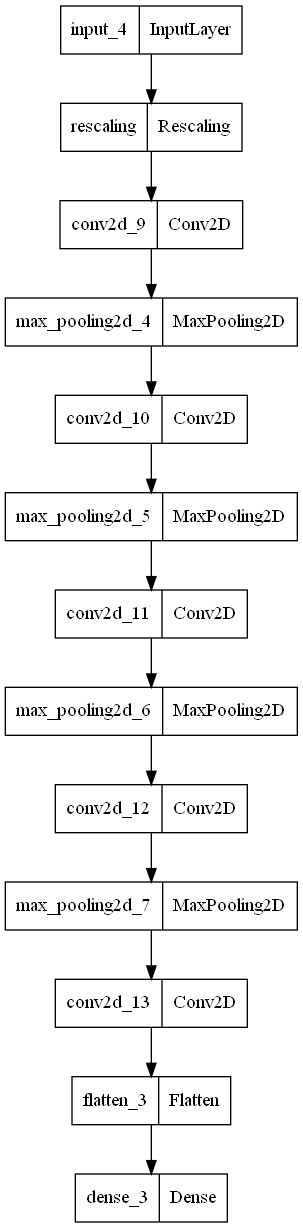

In [20]:
keras.utils.plot_model(model,'CNN.png')

Listing 8.8 Configuring the model for training

In [21]:
model.compile(
            optimizer = keras.optimizers.RMSprop(),
            loss = keras.losses.BinaryCrossentropy(),
            metrics = ['accuracy']
)

### 8.2.4 Data Preprocessing

Currently, the data sits on a drive as
 JPEG files, so the steps for getting it into the model are roughly as follows:
1.  Read the picture files.
 
2. Decode the JPEG content to RGB grids of pixels.

3. Convert these into floating-point tensors.

4. Resize them to a shared size (we’ll use 180 × 180).

5. Pack them into batches (we’ll use batches of 32 images).

In particular, Keras features the utility function 
__image_dataset_from_directory()__, which lets you quickly set up a data pipeline that can automatically turn
image files on disk into batches of preprocessed tensors. This is what we’ll use here

Calling __image_dataset_from_directory(directory)__ 

1. list the subdirectories of directory and assume each one contains images from one of our classes.

2. Index the image files in each subdirectory

3. Finally it will create and return a
 __tf.data.Dataset__ object configured to read these files, shuffle them, decode them to
 tensors, resize them to a shared size, and pack them into batches.

Listing 8.9 Using image_dataset_from_directory to read images

In [22]:
from keras.utils import image_dataset_from_directory

train_dataset = image_dataset_from_directory(new_base_dir/'train',
                                            image_size=(180,180),
                                            batch_size=32)


test_dataset = image_dataset_from_directory(new_base_dir/'test',
                                            image_size=(180,180),
                                            batch_size=32)


validation_dataset = image_dataset_from_directory(new_base_dir/'validation',
                                                image_size=(180,180),
                                                batch_size=32)

Found 2000 files belonging to 2 classes.
Found 2000 files belonging to 2 classes.
Found 1000 files belonging to 2 classes.


#### Understanding Tensorflow Dataset objects 

+  A Dataset object is an iterator: you can use it in a for loop. It will typically return
batches of input data and labels. You can pass a Dataset object directly to the fit()
method of a Keras model.

+  Asynchronous data prefetching (preprocessing
 the next batch of data while the previous one is being handled by the model, which
 keeps execution flowing without interruptions)

+  The Dataset class also exposes a functional-style API for modifying datasets.

Here is a quick example

In [23]:
import tensorflow as tf
random_numbers = np.random.normal(size=(1000,16))
dataset  = tf.data.Dataset.from_tensor_slices(random_numbers)


In [25]:
for i, element in enumerate(dataset):
    print(element.shape)
    if i >=2 : 
        break

(16,)
(16,)
(16,)


We can use __.batch()__ to batch the data

In [26]:
batched_dataset = dataset.batch(32)

for i, element in enumerate(batched_dataset):
    print(element.shape)
    if i >=2 : 
        break

(32, 16)
(32, 16)
(32, 16)


More broadly, we have access to a range of useful dataset methods, such as:


1 __.shuffle(buffer_size)__—Shuffles elements within a buffer


2 __.prefetch(buffer_size)__—Prefetches a buffer of elements in GPU memory
 to achieve better device utilization.


3 __.map(callable)__—Applies an arbitrary transformation to each element of the
 dataset (the function callable, which expects to take as input a single ele ment yielded by the dataset)

Among them the __.map()__ is the one that you will see often, Which is always combined with __lambda__

In [27]:
reshaped_dataset = dataset.map(lambda x : tf.reshape(x,(4,4)))


for i, element in enumerate(reshaped_dataset):
    print(element.shape)
    if i >=2 : 
        break

(4, 4)
(4, 4)
(4, 4)


Let’s look at the output of one of these Dataset objects: it yields batches of 180 × 180
RGB images __(shape (32, 180, 180, 3))__ and integer labels __(shape (32,))__. There are
32 samples in each batch (the batch size).

Listing 8.10 Displaying the shapes of the data and labels yielded by the Dataset

In [29]:

for data_batch, label_batch in train_dataset:
    print("The data batch size = {}".format(data_batch.shape))
    print("The label batch size = {}".format(label_batch.shape))
    break

The data batch size = (32, 180, 180, 3)
The label batch size = (32,)


Note that we’ll also use a ModelCheckpoint callback to save the model after each
 epoch.

__save_best_only=True__ and __monitor="val_loss"__

This guarantees
 that your saved file will always contain the state of the model corresponding to its best performing training epoch, in terms of its performance on the validation data. 
 
 As a
 result, we won’t have to retrain a new model for a lower number of epochs if we start
 overfitting: we can just reload our saved file.



Listing 8.11 Fitting the model using a Dataset

In [79]:
callbacks = [
        keras.callbacks.ModelCheckpoint(
            filepath = "E:\\Python-Machine-Learning\\Deep_Learning_With_python\\Model_8_2\\convert_from_scratch.keras",
            save_best_only= True,
            monitor = 'val_loss'
        )
]

In [80]:
history = model.fit(
                train_dataset,
                epochs = 30 ,
                validation_data = (validation_dataset),
                callbacks = callbacks
)

Epoch 1/30
63/63 [==============================] - 4s 66ms/step - loss: 0.0909 - accuracy: 0.9915 - val_loss: 5.8455 - val_accuracy: 0.7440
Epoch 2/30
63/63 [==============================] - 4s 68ms/step - loss: 0.0657 - accuracy: 0.9900 - val_loss: 5.4401 - val_accuracy: 0.7650
Epoch 3/30
63/63 [==============================] - 4s 70ms/step - loss: 0.0736 - accuracy: 0.9905 - val_loss: 5.3393 - val_accuracy: 0.7570
Epoch 4/30
63/63 [==============================] - 4s 67ms/step - loss: 0.1057 - accuracy: 0.9840 - val_loss: 5.6907 - val_accuracy: 0.7250
Epoch 5/30
63/63 [==============================] - 4s 66ms/step - loss: 0.0324 - accuracy: 0.9945 - val_loss: 6.5997 - val_accuracy: 0.7500
Epoch 6/30
63/63 [==============================] - 4s 66ms/step - loss: 0.0942 - accuracy: 0.9885 - val_loss: 6.5453 - val_accuracy: 0.7450
Epoch 7/30
63/63 [==============================] - 4s 67ms/step - loss: 0.0550 - accuracy: 0.9910 - val_loss: 7.7007 - val_accuracy: 0.7330
Epoch 8/30
63

Listing 8.12 Displaying curves of loss and accuracy during training

In [81]:
from matplotlib import pyplot as plt

accuarcy = history.history['accuracy']
loss = history.history['loss']

val_accuarcy = history.history['val_accuracy']
val_loss = history.history['val_loss']

epochs = np.arange(1,len(loss)+1)



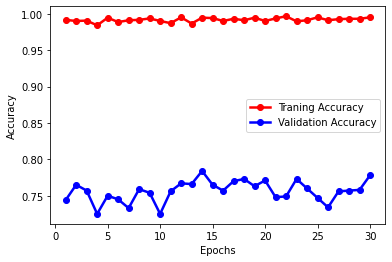

In [82]:
plt.plot(epochs,accuarcy,'-or',lw=2.5,label = 'Traning Accuracy')
plt.plot(epochs,val_accuarcy,'-ob',lw=2.5,label = 'Validation Accuracy')
plt.legend()
plt.xlabel("Epochs")
plt.ylabel('Accuracy')
plt.show()

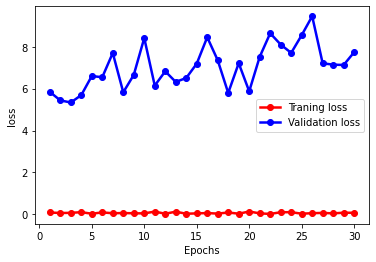

In [83]:
plt.plot(epochs,loss,'-or',lw=2.5,label = 'Traning loss')
plt.plot(epochs,val_loss,'-ob',lw=2.5,label = 'Validation loss')
plt.legend()
plt.xlabel("Epochs")
plt.ylabel('loss')
plt.show()


These plots are characteristic of overfitting. The training accuracy increases linearly
over time, until it reaches nearly 100%, whereas the validation accuracy peaks at 75%.
The validation loss reaches its minimum after only ten epochs and then stalls, whereas
the training loss keeps decreasing linearly as training proceeds.
 
 
 Let’s check the test accuracy. We’ll reload the model from its saved file to evaluate
it as it was before it started overfitting

Listing 8.13 Evaluating the model on the test set

In [84]:
test_model = keras.models.load_model("E:\\Python-Machine-Learning\\Deep_Learning_With_python\\Model_8_2\\convert_from_scratch.keras")



In [85]:
test_loss, test_acc  = test_model.evaluate(test_dataset)
print("Test accuracy = {:.4f}".format(test_acc))

63/63 [==============================] - 2s 27ms/step - loss: 5.1648 - accuracy: 0.7505
Test accuracy = 0.7505


Because we have relatively few training samples (2,000), overfitting will be our
number one concern. 

You already know about a number of techniques that can help
mitigate overfitting, such as dropout and weight decay (L2 regularization). 

We’re now going to work with a new one, specific to computer vision and used almost universally
when processing images with deep learning models: $data$ $augmentation$.

### 8.2.5 Using data Argumentation

Data augmentation takes the approach of generating more training data
from existing training samples by $augmenting$ the samples via a number of random
 transformations that yield believable-looking images

 The __goal__ is that, at training time,
 __your model will never see the exact same picture twice__.

In Keras, this can be done by adding a number of data augmentation layers at the
 start of your model

Listing 8.14 Define a data augmentation stage to add to an image model

In [86]:
data_argumentation = keras.Sequential([
                layers.RandomFlip('horizontal'),
                layers.RandomRotation(0.1),
                layers.RandomZoom(0.2)
])

1. __RandomFlip("horizontal")__—Applies horizontal flipping to a random 50% o 
 the images that go through it


2. __RandomRotation(0.1)__—Rotates the input images by a random value in the range
 [–10%, +10%] (these are fractions of a full circle—in degrees, the range would
 be [–36 degrees, +36 degrees])

3. __RandomZoom(0.2)__—Zooms in or out of the image by a random factor in the
 range [-20%, +20%] 

Listing 8.15 Displaying some randomly augmented training images

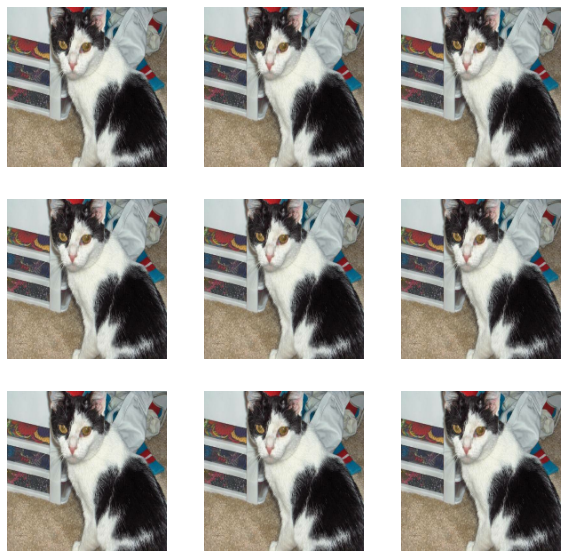

In [87]:
plt.figure(figsize=(10,10))
for images, _ in train_dataset.take(1):
    

    for i in range(9):
        argumed_images = data_argumentation(images)
        ax = plt.subplot(3,3,i+1)
        plt.imshow(argumed_images[0].numpy().astype('uint8'))
        plt.axis('off')


But the inputs it sees are still __heavily intercorrelated__

because they come from a small number of original images—we can’t produce new
 information; we can only remix existing information.



 One last thing you should know about random image augmentation layers: just
like __Dropout__, they’re inactive during __inference__ (when we call __predict()__ or __evaluate()__).


During evaluation, our model will behave just the same as when it did not include
data augmentation and dropout.

Listing 8.16 Defining a new convnet that includes image augmentation and dropout

In [92]:
from tensorflow import keras
from keras import layers

inputs = keras.Input(shape=(180,180,3))

### Adding data_argumentation
inputs = data_argumentation(inputs)

x = layers.Rescaling(1./255)(inputs)

x = layers.Conv2D(filters=32,kernel_size=3,activation='relu')(x)
x = layers.MaxPooling2D(pool_size=2)(x)

x = layers.Conv2D(filters=64,kernel_size=3,activation='relu')(x)
x = layers.MaxPooling2D(pool_size=2)(x)

x = layers.Conv2D(filters=128,kernel_size=3,activation='relu')(x)
x = layers.MaxPooling2D(pool_size=2)(x)

x = layers.Conv2D(filters=256,kernel_size=3,activation='relu')(x)
x = layers.MaxPooling2D(pool_size=2)(x)

x = layers.Conv2D(filters=256,kernel_size=3,activation='relu')(x)
x = layers.Flatten()(x)

### Addition Dropout
x = layers.Dropout(rate=0.5)(x)

outputs = layers.Dense(1,activation='sigmoid')(x)

model = keras.Model(inputs,outputs)


model = keras.Model(inputs=inputs, outputs=outputs)
model.compile(loss="binary_crossentropy",
 optimizer="rmsprop",
 metrics=["accuracy"])

Listing 8.17 Training the regularized convnet

In [93]:
callbacks = [
        keras.callbacks.ModelCheckpoint(
            filepath = "E:\\Python-Machine-Learning\\Deep_Learning_With_python\\Model_8_2\\convert_from_scratch_with_argumentation.keras",
            save_best_only= True,
            monitor = 'val_loss'
        )
]

In [94]:
history = model.fit(
                train_dataset,
                epochs = 100 ,
                validation_data = (validation_dataset),
                callbacks = callbacks,
                verbose = 0
)

In [69]:
from matplotlib import pyplot as plt

accuarcy = history.history['accuracy']
loss = history.history['loss']

val_accuarcy = history.history['val_accuracy']
val_loss = history.history['val_loss']

epochs = np.arange(1,len(loss)+1)

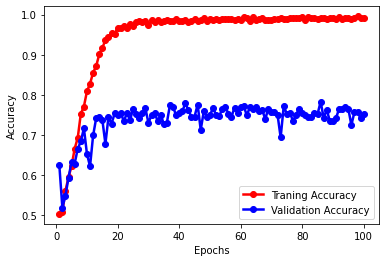

In [70]:
plt.plot(epochs,accuarcy,'-or',lw=2.5,label = 'Traning Accuracy')
plt.plot(epochs,val_accuarcy,'-ob',lw=2.5,label = 'Validation Accuracy')
plt.legend()
plt.xlabel("Epochs")
plt.ylabel('Accuracy')
plt.show()

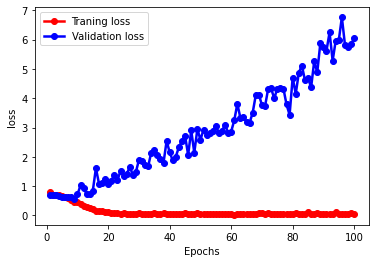

In [71]:
plt.plot(epochs,loss,'-or',lw=2.5,label = 'Traning loss')
plt.plot(epochs,val_loss,'-ob',lw=2.5,label = 'Validation loss')
plt.legend()
plt.xlabel("Epochs")
plt.ylabel('loss')
plt.show()

In [104]:
test_model = keras.models.load_model("E:\\Python-Machine-Learning\\Deep_Learning_With_python\\Model_8_2\\convert_from_scratch_with_argumentation.keras")



In [105]:
test_loss, test_acc  = test_model.evaluate(test_dataset)
print("Test accuracy = {:.3f}".format(test_acc))

63/63 [==============================] - 2s 28ms/step - loss: 0.5345 - accuracy: 0.7505
Test accuracy = 0.751


By further tuning the model’s configuration (such as the number of filters per
convolution layer, or the number of layers in the model), we might be able to get an
even better accuracy, likely up to 90%. 

But it would prove difficult to go any higher
just by training our own convnet from scratch, because we have so little data to work
with. 

As a next step to improve our accuracy on this problem, we’ll have to use a pretrained model, which is the focus of the next two sections.

## 8.3 Leveraging a pretrained model 

A common and highly effective approach to deep learning on small image datasets is
 to use a pretrained model.

If this original dataset is large enough and general enough, the spatial hierarchy of features learned by
 the pretrained model can effectively act as a generic model of the visual world, and
 hence, its features can prove useful for many different computer vision problems,
 even though these new problems may involve completely different classes than those
 of the original task.

There are two ways to use a pretrained model: feature extraction and fine-tuning.
 We’ll cover both of them. Let’s start with feature extraction.

### 8.3.1 Feature Extraction with a pretrained model

Feature extraction consists of using the representations learned by a previously
 trained model to extract interesting features from new samples. These features are
 then run through a new classifier, which is trained from scratch.

Why only reuse the convolutional base? 

Could we reuse the densely connected classifier as well?

__NO__

Reason:

1. The __representations learned by the convolutional base__ are likely to be __more generic__ and, therefore, more reusable: the feature maps of a convnet are presence maps of generic
 concepts over a picture, which are likely to be useful regardless of the computer vision
 problem at hand.

    + But the __representations learned by the classifier__ will necessarily be
 __specific__ to the set of classes on which the model was trained—they will only contain
 information about the presence probability of this or that class in the entire picture.


2. Representations found in __densely connected layers__   __no longer contain any information about where objects are located in the input image__; 

   + these layers get rid of 
 the notion of space, whereas the object location is still described by convolutional fea ture maps. For problems where object location matters, densely connected features
 are largely useless.


#### NOTE: 
+  The __level of generality__ (and therefore reusability) of the representations
 extracted by specific convolution layers __depends on the depth of the layer in the
 model__

+  Layers that come __earlier__ in the model extract local, __highly generic feature
 maps__ (such as visual edges, colors, and textures), whereas layers that are higher up
 extract more-abstract concepts (such as “cat ear” or “dog eye”).

 In this case, because the __ImageNet__ class set contains multiple dog and cat
classes, it’s likely to be beneficial to reuse the information contained in the densely
connected layers of the original model.

The $VGG16$ model, among others, comes prepackaged with Keras. 

You can import
it from the __keras.applications__ module. Many other image-classification models (all
pretrained on the ImageNet dataset) are available as part of keras.applications:

1. Xception
2. ResNet
3. MobileNet
4. EfficientNet
5. DenseNet
6. etc.

Listing 8.19 Instantiating the VGG16 convolutional base

In [106]:
conv_base = keras.applications.vgg16.VGG16(
    weights = 'imagenet',
    include_top = False,
    input_shape = (180,180,3)
)

58889256/58889256 [==============================] - 5s 0us/step


1. __weights__ specifies the weight checkpoint from which to initialize the model.


2. __include_top__ refers to including (or not) the __densely connected classifier on
top of the network__. By default, this densely connected classifier corresponds to
the 1,000 classes from ImageNet. Because we intend to use our own densely
connected classifier (with only two classes: cat and dog), we don’t need to
include it.

3. __input_shape__ is the shape of the image tensors that we’ll feed to the network.
This argument is purely optional: if we don’t pass it, the network will be able to
process inputs of any size. Here we pass it so that we can visualize (in the follow ing summary) how the size of the feature maps shrinks with each new convolu tion and pooling layer.

Here is the summary of VGG16

In [110]:
conv_base.summary()

Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_17 (InputLayer)       [(None, 180, 180, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 180, 180, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 180, 180, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 90, 90, 64)        0         
                                                                 
 block2_conv1 (Conv2D)       (None, 90, 90, 128)       73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 90, 90, 128)       147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 45, 45, 128)       0     

The final feature map has shape (5, 5, 512). That’s the feature map on top of which
we’ll stick a densely connected classifier.
 At this point, there are two ways we could proceed:


1. Run the convolutional base over our dataset, record its output to a NumPy array
on disk, and then use this data as input to a standalone, densely connected classifier similar to those you saw in chapter 4 of this book. This solution is fast and
cheap to run, because it only requires running the convolutional base once for
every input image, and the convolutional base is by far the most expensive part
of the pipeline. But for the same reason, this technique __won’t allow us to use
data augmentation__.



2. Extend the model we have (conv_base) by __adding Dense layers on top__, and run
the whole thing from end to end on the input data. This will __allow us to use
data augmentation__, because every input image goes through the convolutional
base every time it’s seen by the model. But for the same reason, this technique is
far more __expensive__ than the first.

#### FAST FEATURE EXTRACTION WITHOUT DATA AUGMENTATION

Listing 8.20 Extracting the VGG16 features and corresponding labels

In [111]:
import numpy as np 

def get_features_and_lables(dataset):
    all_features = []
    all_labels  = []
    for images,labels in dataset:
        
        proprecessed_images = keras.applications.vgg16.preprocess_input(images)
        
        ## Since we didn't extract the upper classification dense layer, the predction of the conv_base is a series of features
        features = conv_base.predict(proprecessed_images)
        all_features.append(features)
        all_labels.append(labels)
    
    return np.concatenate(all_features),np.concatenate(all_labels)



In [112]:
train_features,train_labels = get_features_and_lables(train_dataset)

val_features,val_labels = get_features_and_lables(validation_dataset)

test_features,test_labels = get_features_and_lables(test_dataset)

1/1 [==============================] - 0s 19ms/step


Importantly, __predict()__ only expects images, not labels, but our current dataset yields
batches that contain both images and their labels. 

Moreover, the VGG16 model expects
inputs that are preprocessed with the function __keras.applications.vgg16.preprocess_input__, which scales pixel values to an appropriate range

In [113]:
train_features.shape

(2000, 5, 5, 512)

At this point, we can define our densely connected classifier (note the use of dropout
for regularization) and train it on the data and labels that we just recorded.

Listing 8.21 Defining and training the densely connected classifier

In [133]:
inputs = keras.Input(shape=(5,5,512))
x = layers.Flatten()(inputs)

x = layers.Dense(256)(x)
x = layers.Dropout(0.5)(x)
outputs = layers.Dense(1,activation='sigmoid')(x)
model = keras.Model(inputs,outputs)

model.compile(optimizer=keras.optimizers.RMSprop(),
                loss = keras.losses.BinaryCrossentropy(),
                metrics = ['accuracy']
                )

callbacks = [
            keras.callbacks.ModelCheckpoint(
                filepath = "E:\\Python-Machine-Learning\\Deep_Learning_With_python\\Model_8_2\\feature_extraction.keras",
                save_best_only = True,
                monitor = 'val_loss'
            )
 ]

In [134]:
history = model.fit(
                    train_features,train_labels,
                    epochs=20,
                    validation_data = (val_features,val_labels),
                    callbacks = callbacks
)

Epoch 1/20
63/63 [==============================] - 1s 16ms/step - loss: 12.3364 - accuracy: 0.9245 - val_loss: 4.5694 - val_accuracy: 0.9690
Epoch 2/20
63/63 [==============================] - 1s 9ms/step - loss: 4.8153 - accuracy: 0.9735 - val_loss: 4.3400 - val_accuracy: 0.9730
Epoch 3/20
63/63 [==============================] - 1s 9ms/step - loss: 1.3098 - accuracy: 0.9865 - val_loss: 5.6357 - val_accuracy: 0.9680
Epoch 4/20
63/63 [==============================] - 1s 9ms/step - loss: 1.1428 - accuracy: 0.9910 - val_loss: 5.4104 - val_accuracy: 0.9730
Epoch 5/20
63/63 [==============================] - 1s 10ms/step - loss: 1.3096 - accuracy: 0.9915 - val_loss: 4.9230 - val_accuracy: 0.9800
Epoch 6/20
63/63 [==============================] - 1s 9ms/step - loss: 1.1771 - accuracy: 0.9925 - val_loss: 4.6752 - val_accuracy: 0.9790
Epoch 7/20
63/63 [==============================] - 1s 9ms/step - loss: 1.3953 - accuracy: 0.9945 - val_loss: 4.4148 - val_accuracy: 0.9780
Epoch 8/20
63/63 

Listing 8.22 Plotting the results

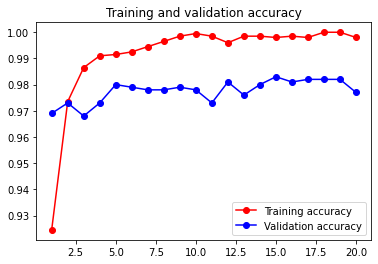

In [135]:
import matplotlib.pyplot as plt
acc = history.history["accuracy"]
val_acc = history.history["val_accuracy"]
loss = history.history["loss"]
val_loss = history.history["val_loss"]
epochs = range(1, len(acc) + 1)
plt.plot(epochs, acc, "-or", label="Training accuracy")
plt.plot(epochs, val_acc, "-ob", label="Validation accuracy")
plt.title("Training and validation accuracy")
plt.legend()


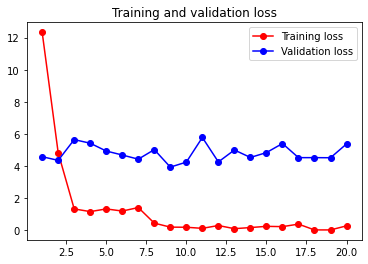

In [136]:
plt.figure()
plt.plot(epochs, loss, "-or", label="Training loss")
plt.plot(epochs, val_loss, "-ob", label="Validation loss")
plt.title("Training and validation loss")
plt.legend()
plt.show()

We reach a validation accuracy of about 97%—much better than we achieved in the
previous section with the small model trained from scratch.

However, the plots also indicate that we’re overfitting almost from the start—
 despite using dropout with a fairly large rate. That’s because this technique __doesn’t
 use data augmentation__, which is essential for preventing overfitting with small image
 datasets.

#### FEATURE EXTRACTION TOGETHER WITH DATA AUGMENTATION

In order to do this, we will first $freeze$ $the$ $convolutional$ $base$. 

Freezing a layer or set o 
 layers means preventing their weights from being updated during training.
 
If we don’t
 do this, __the representations that were previously learned by the convolutional base will
 be modified during training__. 
 
 Because the Dense layers on top are randomly initialized,
 very large weight updates would be propagated through the network, effectively
 destroying the representations previously learned.

Listing 8.23 Instantiating and freezing the VGG16 convolutional base

In [137]:
conv_base  = keras.applications.vgg16.VGG16(weights='imagenet',
                                        include_top = False
                                )

conv_base.trainable =False

Listing 8.24 Printing the list of trainable weights before and after freezing

In [139]:
conv_base.trainable = True
print("This is the number of trainable weights "
 "before freezing the conv base:", len(conv_base.trainable_weights))

conv_base.trainable = False
print("This is the number of trainable weights "
 "after freezing the conv base:", len(conv_base.trainable_weights))


This is the number of trainable weights before freezing the conv base: 26
This is the number of trainable weights after freezing the conv base: 0


Listing 8.25 Adding a data augmentation stage and a classifier to the convolutional base

In [148]:
data_argumentation = keras.Sequential([
    layers.RandomFlip('horizontal'),
    layers.RandomRotation(0.1),
    layers.RandomZoom(0.2)
])

inputs = keras.Input(shape=(180,180,3))
x = data_argumentation(inputs)
x = keras.applications.vgg16.preprocess_input(x)


x = conv_base(x)
x = layers.Flatten()(x)
x = layers.Dense(256)(x)
x = layers.Dropout(0.5)(x)
outputs = layers.Dense(1,activation='sigmoid')(x)
model = keras.Model(inputs,outputs)

model.compile(optimizer= keras.optimizers.RMSprop(),
                loss = keras.losses.BinaryCrossentropy(),
                metrics = ['accuracy']
    )


callbacks = [
            keras.callbacks.ModelCheckpoint(
                filepath = "E:\\Python-Machine-Learning\\Deep_Learning_With_python\\Model_8_2\\feature_extraction_with_argumentation.keras",
                save_best_only = True,
                monitor = 'val_loss'
            )
 ]

In [149]:
history = model.fit(
                    train_dataset,
                    epochs=50,
                    validation_data = validation_dataset,
                    callbacks = callbacks
)

Epoch 1/50
63/63 [==============================] - 14s 207ms/step - loss: 20.2009 - accuracy: 0.8880 - val_loss: 4.1850 - val_accuracy: 0.9690
Epoch 2/50
63/63 [==============================] - 13s 205ms/step - loss: 6.7448 - accuracy: 0.9480 - val_loss: 6.1696 - val_accuracy: 0.9600
Epoch 3/50
63/63 [==============================] - 13s 204ms/step - loss: 5.9622 - accuracy: 0.9560 - val_loss: 19.3719 - val_accuracy: 0.9180
Epoch 4/50
63/63 [==============================] - 13s 206ms/step - loss: 5.1688 - accuracy: 0.9625 - val_loss: 3.5054 - val_accuracy: 0.9790
Epoch 5/50
63/63 [==============================] - 13s 205ms/step - loss: 5.3111 - accuracy: 0.9650 - val_loss: 3.7229 - val_accuracy: 0.9800
Epoch 6/50
63/63 [==============================] - 13s 207ms/step - loss: 4.7328 - accuracy: 0.9620 - val_loss: 2.8202 - val_accuracy: 0.9790
Epoch 7/50
63/63 [==============================] - 13s 207ms/step - loss: 3.2160 - accuracy: 0.9695 - val_loss: 3.7395 - val_accuracy: 0.97

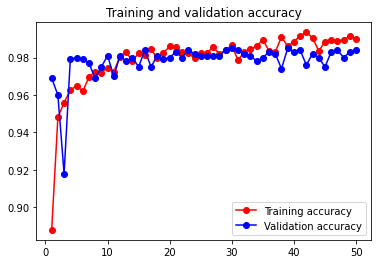

In [150]:
import matplotlib.pyplot as plt
acc = history.history["accuracy"]
val_acc = history.history["val_accuracy"]
loss = history.history["loss"]
val_loss = history.history["val_loss"]
epochs = range(1, len(acc) + 1)
plt.plot(epochs, acc, "-or", label="Training accuracy")
plt.plot(epochs, val_acc, "-ob", label="Validation accuracy")
plt.title("Training and validation accuracy")
plt.legend()


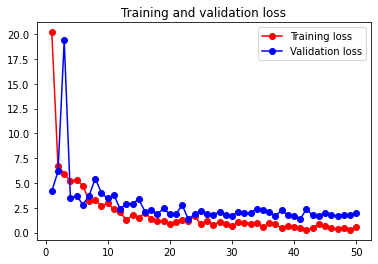

In [151]:
plt.figure()
plt.plot(epochs, loss, "-or", label="Training loss")
plt.plot(epochs, val_loss, "-ob", label="Validation loss")
plt.title("Training and validation loss")
plt.legend()
plt.show()

In [153]:
test_model = keras.models.load_model("E:\\Python-Machine-Learning\\Deep_Learning_With_python\\Model_8_2\\feature_extraction_with_argumentation.keras",
                )

test_loss,test_acc = test_model.evaluate(test_dataset)

print("Accuracy on test dataset is {:.3f}".format(test_acc))

63/63 [==============================] - 8s 114ms/step - loss: 3.2292 - accuracy: 0.9745
Accuracy on test dataset is 0.975


### 8.3.2 Fine-tuning a pretrained model

Another widely used technique for model reuse,
 complementary to feature extraction, is $fine-tuning$


Fine-tuning consists of __unfreezing
 a few of the top layers of a frozen model base used
 for feature extraction__, and jointly training both the
 newly added part of the model (in this case, the
 fully connected classifier) and these top layers.

 It slightly adjusts the
 more abstract representations of the model being
 reused in order to make them more relevant for the
 problem at hand.

For the
 same reason, it’s only possible to fine-tune the __top
 layers of the convolutional base__ once the classifier on
 top has already been trained.

If the classifier isn’t
 already trained, the __error signal__ propagating
 through the network during training __will be too
 large__, and the representations previously learned by
 the layers being fine-tuned will be destroyed

1.Add our custom network on top of an
already-trained base network.


2 Freeze the base network.


3 Train the part we added.


4 Unfreeze some layers in the base network.
(Note that you should not unfreeze “batch
normalization” layers, which are not relevant
here since there are no such layers in VGG16.
Batch normalization and its impact on finetuning is explained in the next chapter.)


5 Jointly train both these layers and the part we
added

You already completed the first three steps when
doing feature extraction. 

Let’s proceed with step __4__:
we’ll unfreeze our conv_base and then freeze individual layers inside it.

In [158]:
conv_base  = keras.applications.vgg16.VGG16(weights='imagenet',
                                        include_top = False,
                                        input_shape = (180,180,3)
                                )

conv_base.trainable =False

conv_base.summary()

Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_37 (InputLayer)       [(None, 180, 180, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 180, 180, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 180, 180, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 90, 90, 64)        0         
                                                                 
 block2_conv1 (Conv2D)       (None, 90, 90, 128)       73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 90, 90, 128)       147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 45, 45, 128)       0     

We’ll fine-tune the __last three convolutional layers__, which means all layers up to block4_
pool should be frozen, and the __layers block5_conv1, block5_conv2, and block5_conv3__
should be trainable.

 Why not fine-tune more layers? Why not fine-tune the entire convolutional base?
You could. But you need to consider the following:


1. __Earlier layers in the convolutional base encode more generic, reusable features__,
whereas layers higher up encode more specialized features. It’s more useful to
fine-tune the more specialized features, because these are the ones that need
to be repurposed on your new problem. There would be fast-decreasing returns
in fine-tuning lower layers.


2. __The more parameters you’re training, the more you’re at risk of overfitting.__
The convolutional base has 15 million parameters, so it would be risky to
attempt to train it on your small dataset.

Listing 8.27 Freezing all layers until the fourth from the last

In [159]:
conv_base.trainable = True

for layer in conv_base.layers[:-4]:
    layer.trainable = False

Now we can begin fine-tuning the model. 

We’ll do this with the __RMSprop__ optimizer,
using a __very low learning rate__. 

The reason for using a low learning rate is that we want to
limit the magnitude of the modifications we make to the representations of the three
layers we’re fine-tuning.

Listing 8.28 Fine-tuning the model

In [161]:
inputs = keras.Input(shape=(180,180,3))
x = data_argumentation(inputs)
x = keras.applications.vgg16.preprocess_input(x)


x = conv_base(x)
x = layers.Flatten()(x)
x = layers.Dense(256)(x)
x = layers.Dropout(0.5)(x)
outputs = layers.Dense(1,activation='sigmoid')(x)
model = keras.Model(inputs,outputs)


model.compile(loss=keras.losses.BinaryCrossentropy(),
              optimizer = keras.optimizers.RMSprop(learning_rate=1e-5),
              metrics = ['accuracy']  
                )


callbacks = [
            keras.callbacks.ModelCheckpoint(
                filepath = "E:\\Python-Machine-Learning\\Deep_Learning_With_python\\Model_8_2\\fine_tuning.keras",
                save_best_only = True,
                monitor = 'val_loss'
            )
 ]

In [162]:
history = model.fit(
                    train_dataset,
                    epochs=30,
                    validation_data = validation_dataset,
                    callbacks = callbacks,
                    verbose = 0
)

In [163]:
test_model = keras.models.load_model("E:\\Python-Machine-Learning\\Deep_Learning_With_python\\Model_8_2\\fine_tuning.keras")

test_loss,test_acc = test_model.evaluate(test_dataset)
print("The accuracy on test dataset is {:.3f}".format(test_acc))

63/63 [==============================] - 8s 117ms/step - loss: 0.1810 - accuracy: 0.9740
The accuracy on test dataset is 0.974


On the positive side, by leveraging modern deep learning techniques, we managed
 to reach this result using only a small fraction of the training data that was available
 for the competition (about 10%). 
 
There is a huge difference between being able to
 train on 20,000 samples compared to 2,000 samples!

## Summary

+ Convnets are the best type of machine learning models for computer vision
tasks. It’s possible to train one from scratch even on a very small dataset, with
decent results.

+  Convnets work by learning a hierarchy of modular patterns and concepts to
represent the visual world.

+ On a small dataset, overfitting will be the main issue. Data augmentation is a
powerful way to fight overfitting when you’re working with image data.

+ It’s easy to reuse an existing convnet on a new dataset via feature extraction.
This is a valuable technique for working with small image datasets.

+ As a complement to feature extraction, you can use fine-tuning, which adapts to
a new problem some of the representations previously learned by an existing
model. This pushes performance a bit further.